In [14]:
import numpy as np
import xarray as xr
import scipy.linalg
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from nearestPD import nearestPD
invm = np.linalg.inv



ds_2 = xr.open_dataset("data/regions_verify_202104_cov.nc")
bio_2 = ds_2["covariance_bio"]
anth_2 = ds_2["covariance_anth"]

M = bio_2
# determine threshold
thresh0 = 1e-4
thresh1 = 1e-8
thresh2 = 1e-12

# new thresholded matrix
M0 = np.where(abs(M) < thresh0, 0, M)
M1 = np.where(abs(M) < thresh1, 0, M)
M2 = np.where(abs(M) < thresh2, 0, M)


M0_binary = xr.DataArray(np.where(M0 != 0.0, 1.0, M0))
M1_binary = xr.DataArray(np.where(M1 != 0.0, 1.0, M1))
M2_binary = xr.DataArray(np.where(M2 != 0.0, 1.0, M2))

# nearest non-singular to M0

#M0pd = nearestPD(M0)

#M0i = np.linalg.inv(M0)
# %timeit np.linalg.inv(M)



Visual check
* where the non-zero elements of the matrix are after setting the threshold
* nearest nonsingular 

In [12]:






fig, ax = plt.subplots(figsize = (11,9), layout= 'constrained')
M0_binary.plot.pcolormesh(yincrease = False)
ax.set_xlabel("nstate")
ax.set_ylabel("nstate")
plt.show()


#fig, ax = plt.subplots(layout = 'constrained')
#M0pd_binary.plot.pcolormesh(yincrease = False)





Text(0.5, 0.1, 'Non-zero values in covariance matrix bio_2 using different threshold values')

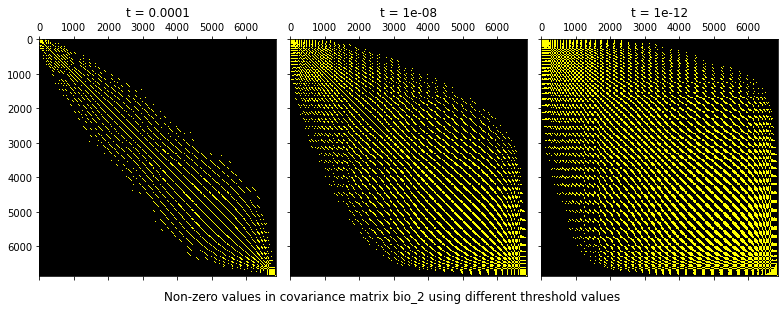

In [26]:



cmap = colors.ListedColormap(['black', 'yellow'])
fig, axs = plt.subplots(1, 3, figsize = (11, 5), layout = 'tight', sharey='row')
axs[0].matshow(M0_binary, cmap=cmap)
axs[0].set_title(f"t = {thresh0}")
axs[1].matshow(M1_binary, cmap=cmap)
axs[1].set_title(f"t = {thresh1}")
axs[2].matshow(M2_binary, cmap=cmap)
axs[2].set_title(f"t = {thresh2}")
fig.suptitle(f"Non-zero values in covariance matrix bio_2 using different threshold values", y=0.1)



<xarray.DataArray ()>
array(0.) 0.0 0.24086587722293318 <xarray.DataArray ()>
array(0.8)


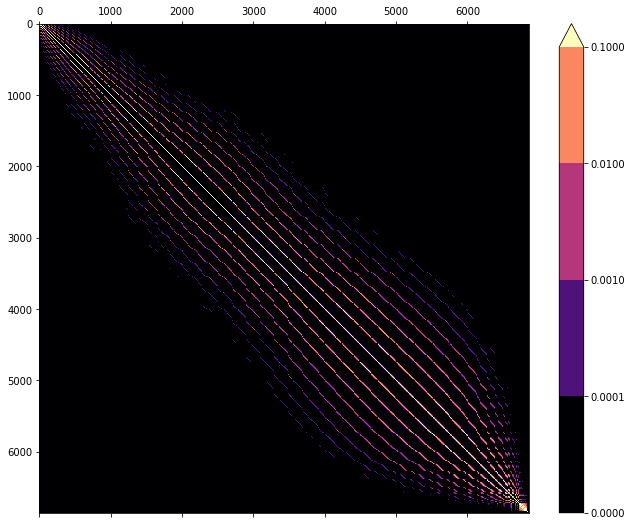

In [3]:
M0 = xr.DataArray(M0)
qlower = np.quantile(M0, 0.001)
qupper = np.quantile(M0, 0.999)
vmin = np.min(M0)
vmax = np.max(M0)
print(vmin, qlower, qupper, vmax)

fig, ax = plt.subplots(figsize = (11,9))
bounds = np.array([0., 1e-4, 1e-3, 1e-2, 1e-1])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='max')
pcm = ax.matshow(M0, norm=norm, cmap='magma')
# The colorbar inherits the "extend" argument from BoundaryNorm.
fig.colorbar(pcm, ax=ax, orientation='vertical')
plt.show()

Yksinkertainen blokkijako
---------------------------

* Isommat blokit alakulmassa, koska siellä näyttäisi olevan leveämmällä "isoja" arvoja
* Inversionin vois oikeestaan tehdä in-place ja samalla muuttaa nolliksi kaikki muut arvot
* Vai onko parempi koota uusi block_diag matriisi käännetyistä? (vrt. ei tarvitse ladata koko matriisia muistiin)

In [3]:
from block_diag_inverse import block_diag_inv

Tests to see if functions work as intended
-------------------------------------------

In [6]:

nblocks = 2

testM = np.eye(9)*2
# testblocks = get_blocks(testM, nblocks)
# itest = invert_combine(testblocks)
# print(itest)

In [7]:


itestM = block_diag_inv(testM)
print(itestM)



[[0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.5 0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5]]


In [4]:
blocks = get_blocks(M.values,5)
M_block_diag = scipy.linalg.block_diag(*blocks)




fig, ax = plt.subplots(figsize = (11,9))
bounds = np.array([-1e-1 ,-1e-2,-1e-3,-1e-4, 1e-4, 1e-3, 1e-2, 1e-1])
#bounds = np.array([0., 1e-4, 1e-3, 1e-2, 1e-1, 0.8])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
pcm = ax.matshow(M_block_diag, norm=norm, cmap='RdBu_r')
# The colorbar inherits the "extend" argument from BoundaryNorm.
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink = 0.7)
plt.show()



NameError: name 'get_blocks' is not defined

In [5]:
iM_block_diag = block_diag_inv(M)
iM = invm(M)

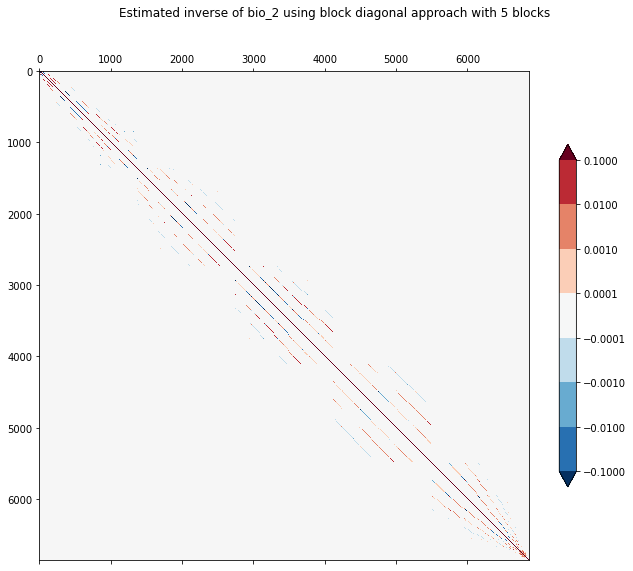

In [6]:



fig, ax = plt.subplots(figsize = (11,9))
bounds = np.array([-1e-1 ,-1e-2,-1e-3,-1e-4, 1e-4, 1e-3, 1e-2, 1e-1])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
pcm = ax.matshow(iM_block_diag, norm=norm, cmap='RdBu_r')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink = 0.7)
fig.suptitle("Estimated inverse of bio_2 using block diagonal approach with 5 blocks")
plt.show()


In [7]:
matrices = [M, iM, M_block_diag, iM_block_diag]
names = ["Cov_bio", "Inverse of Cov_bio", "Block diagonal Cov_bio", "Inverse of block diagonal Cov_bio"]

fig, axs = plt.subplots(2,2, figsize = (15,13), layout = 'constrained')
bounds = np.array([-1e-1 ,-1e-2,-1e-3,-1e-4, -1e-5, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
images = []
for k in range(4):
    i = k // 2
    j = k-2*i
    images.append(axs[i,j].matshow(matrices[k], cmap='RdBu_r'))
    axs[i,j].set_title(names[k])
for im in images:
    im.set_norm(norm)

fig.colorbar(im, ax=axs.ravel().tolist(), norm = norm, orientation = 'vertical', shrink = 0.8)
plt.show()

NameError: name 'M_block_diag' is not defined

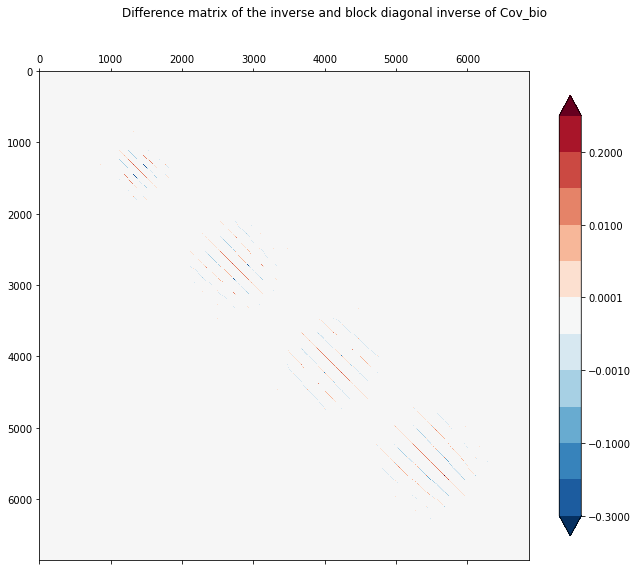

In [8]:


diff = iM-iM_block_diag

fig, ax = plt.subplots(figsize = (11,9))
bounds = np.array([-3e-1,-2e-1, -1e-1 ,-1e-2,-1e-3,-1e-4, 1e-4, 1e-3, 1e-2, 1e-1, 2e-1, 3e-1])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend='both')
pcm = ax.matshow(diff, norm=norm, cmap='RdBu_r')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink = 0.9)
fig.suptitle("Difference matrix of the inverse and block diagonal inverse of Cov_bio")
plt.show()

Some statistics on the difference matrix

In [9]:
mindiff = np.min(diff)
maxdiff = np.max(diff)
qldiff = np.quantile(diff, 0.005)
qudiff = np.quantile(diff, 0.995)
print(f"Largest (absolute) difference values: {mindiff}, {maxdiff}")
print(f"99 % difference values within interval: {qldiff}, {qudiff}")

Largest (absolute) difference values: -1.3772566086538924, 0.8771725660130585
99 % difference values within interval: -1.8726090550098484e-06, 4.600050148447635e-06
